# 问题
$-u^{''}(x)=f(x), u(0)=u(1)=0$

其中
$f(x) = -(2\cos x-(x-1)\sin x)$

真解
$u(x) = x\sin x$

In [1]:
import numpy as np

# 划分网格
N = 100
x0 = 0
x1 = 1 
x = np.linspace(x0, x1, N+2) # cell edges
# xc = (x[1:] + x[:-1]) / 2   # cell centers

global dx
dx = x[1] - x[0]

In [2]:
# 计算a(phi_i, phi_j)  
def a(phi1:int, phi2:int):
    if phi1 == phi2:
        return 2.0 / dx
    elif phi1 == phi2 + 1:
        return -1.0 / dx
    elif phi1 == phi2 - 1:
        return -1.0 / dx
    else:
        return 0


def f(x):
    return -(2*np.cos(x) - (x-1)*np.sin(x))

# 计算F(phi_i)
def F(phi:int):
    return f(x[phi]) * dx  #高斯积分

In [3]:
A = np.zeros((N, N))
B = np.zeros(N)
for i in range(N):
    for j in range(N):
        A[i, j] = a(i, j)
    B[i] = F(i)

In [4]:
k = np.linalg.solve(A, B)

/home/xxm/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


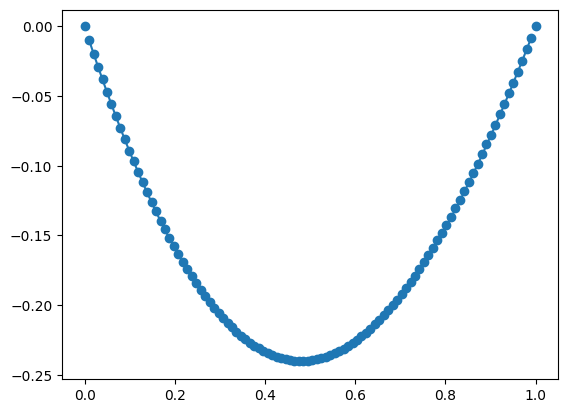

In [5]:
u_real = (x - 1) * np.sin(x)

import matplotlib.pyplot as plt
plt.plot(x[1:-1], k)
plt.scatter(x, u_real)
plt.show()

# DG
$\frac{\partial{u}}{\partial{t}} + \frac{\partial{f(u)}}{\partial{x}} = 0$

$u(x,0) = \sin x$

In [ ]:
def init_data(): # 赋初值
    pass

def get_basic(): #基函数在Gauss点和端点的值
    pass

def L2_pro(): # L2投影
    pass

def RK3(): # RK3格式
    pass

def calc_L2_error(): # 计算L2误差
    pass

In [6]:
def get_GLP(NumGLP): # 获取高斯积分点和权重
    if(NumGLP == 5):
        point = np.array([-0.9061798459386640, -0.5384693101056831 ,0, 0.5384693101056831 , 0.9061798459386640])
        weight = np.array([0.2369268850561891, 0.4786286704993665, 0.5688888888888889,  0.4786286704993665,  0.2369268850561891])
        return point, weight

In [8]:
def f(x):
    return np.sin(x)

In [ ]:
Nx = 100
k = 2 # 多项式阶数
NumGLP = 2*k + 1 # 高斯积分点数
dimPk = k + 1 # Pk空间维数
CFL = 0.2

xa = 0
xb = 2 * np.pi
bcL = 1
bcR = 1